# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Novrian Pratama
- **Email:** novrianprtama2@gmail.com
- **ID Dicoding:** novrian_pratama2

## Import Semua Packages/Library yang Digunakan

In [15]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from skimage.transform import resize

# untuk pembangunan model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"novrian02","key":"2c374dd593ff070d6cabd7a1865d2a38"}'}

In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
# unduh dataset image
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d brain-tumor-data

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0725.jpg  
  inflating: brain-tumor-data/Training/glioma/Tr-gl_0726.jp

### Eksplorasi Dataset

In [19]:
dataset_path = "/content/brain-tumor-data/Training"

# Cek kelas yang tersedia
classes  = os.listdir(dataset_path)
print('Kelas yang tersedia:', classes)

# Hitung jumlah gambar per kelas
for class_name in classes:
  class_path = os.path.join(dataset_path, class_name)
  num_images = len(os.listdir(class_path))
  print(f'{class_name}: {num_images} gambar')

Kelas yang tersedia: ['meningioma', 'pituitary', 'glioma', 'notumor']
meningioma: 1339 gambar
pituitary: 1457 gambar
glioma: 1321 gambar
notumor: 1595 gambar


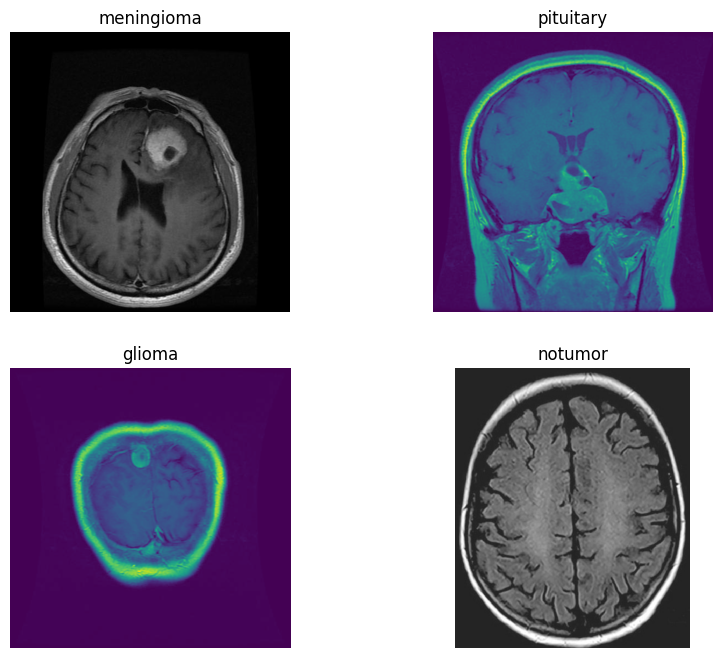

In [20]:
# Visualisasi contoh gambar
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)

  img = Image.open(img_path)
  plt.subplot(2, 2, i+1)
  plt.imshow(img)
  plt.title(class_name)
  plt.axis('off')
plt.show()

### Data Preprocessing

#### Split Dataset

In [21]:
# Split Dataset (Training, Validation, Testing)
# ukuran gambar dan batch size
img_width, img_height = 150, 150
batch_size = 32

# Generator untuk data TRAINING dengan augmentasi + validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Generator untuk data TESTING (hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path dataset
train_dir = '/content/brain-tumor-data/Training'
test_dir = '/content/brain-tumor-data/Testing'

# Generator untuk training set (80%)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Generator untuk validation set (20%)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Generator untuk testing set (folder terpisah)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Cek distribusi
print("Jumlah gambar per subset:")
print(f"- Training: {train_generator.samples} gambar")
print(f"- Validation: {val_generator.samples} gambar")
print(f"- Testing: {test_generator.samples} gambar")

print("\nKelas dan indeks:")
print(train_generator.class_indices)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Jumlah gambar per subset:
- Training: 4571 gambar
- Validation: 1141 gambar
- Testing: 1311 gambar

Kelas dan indeks:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


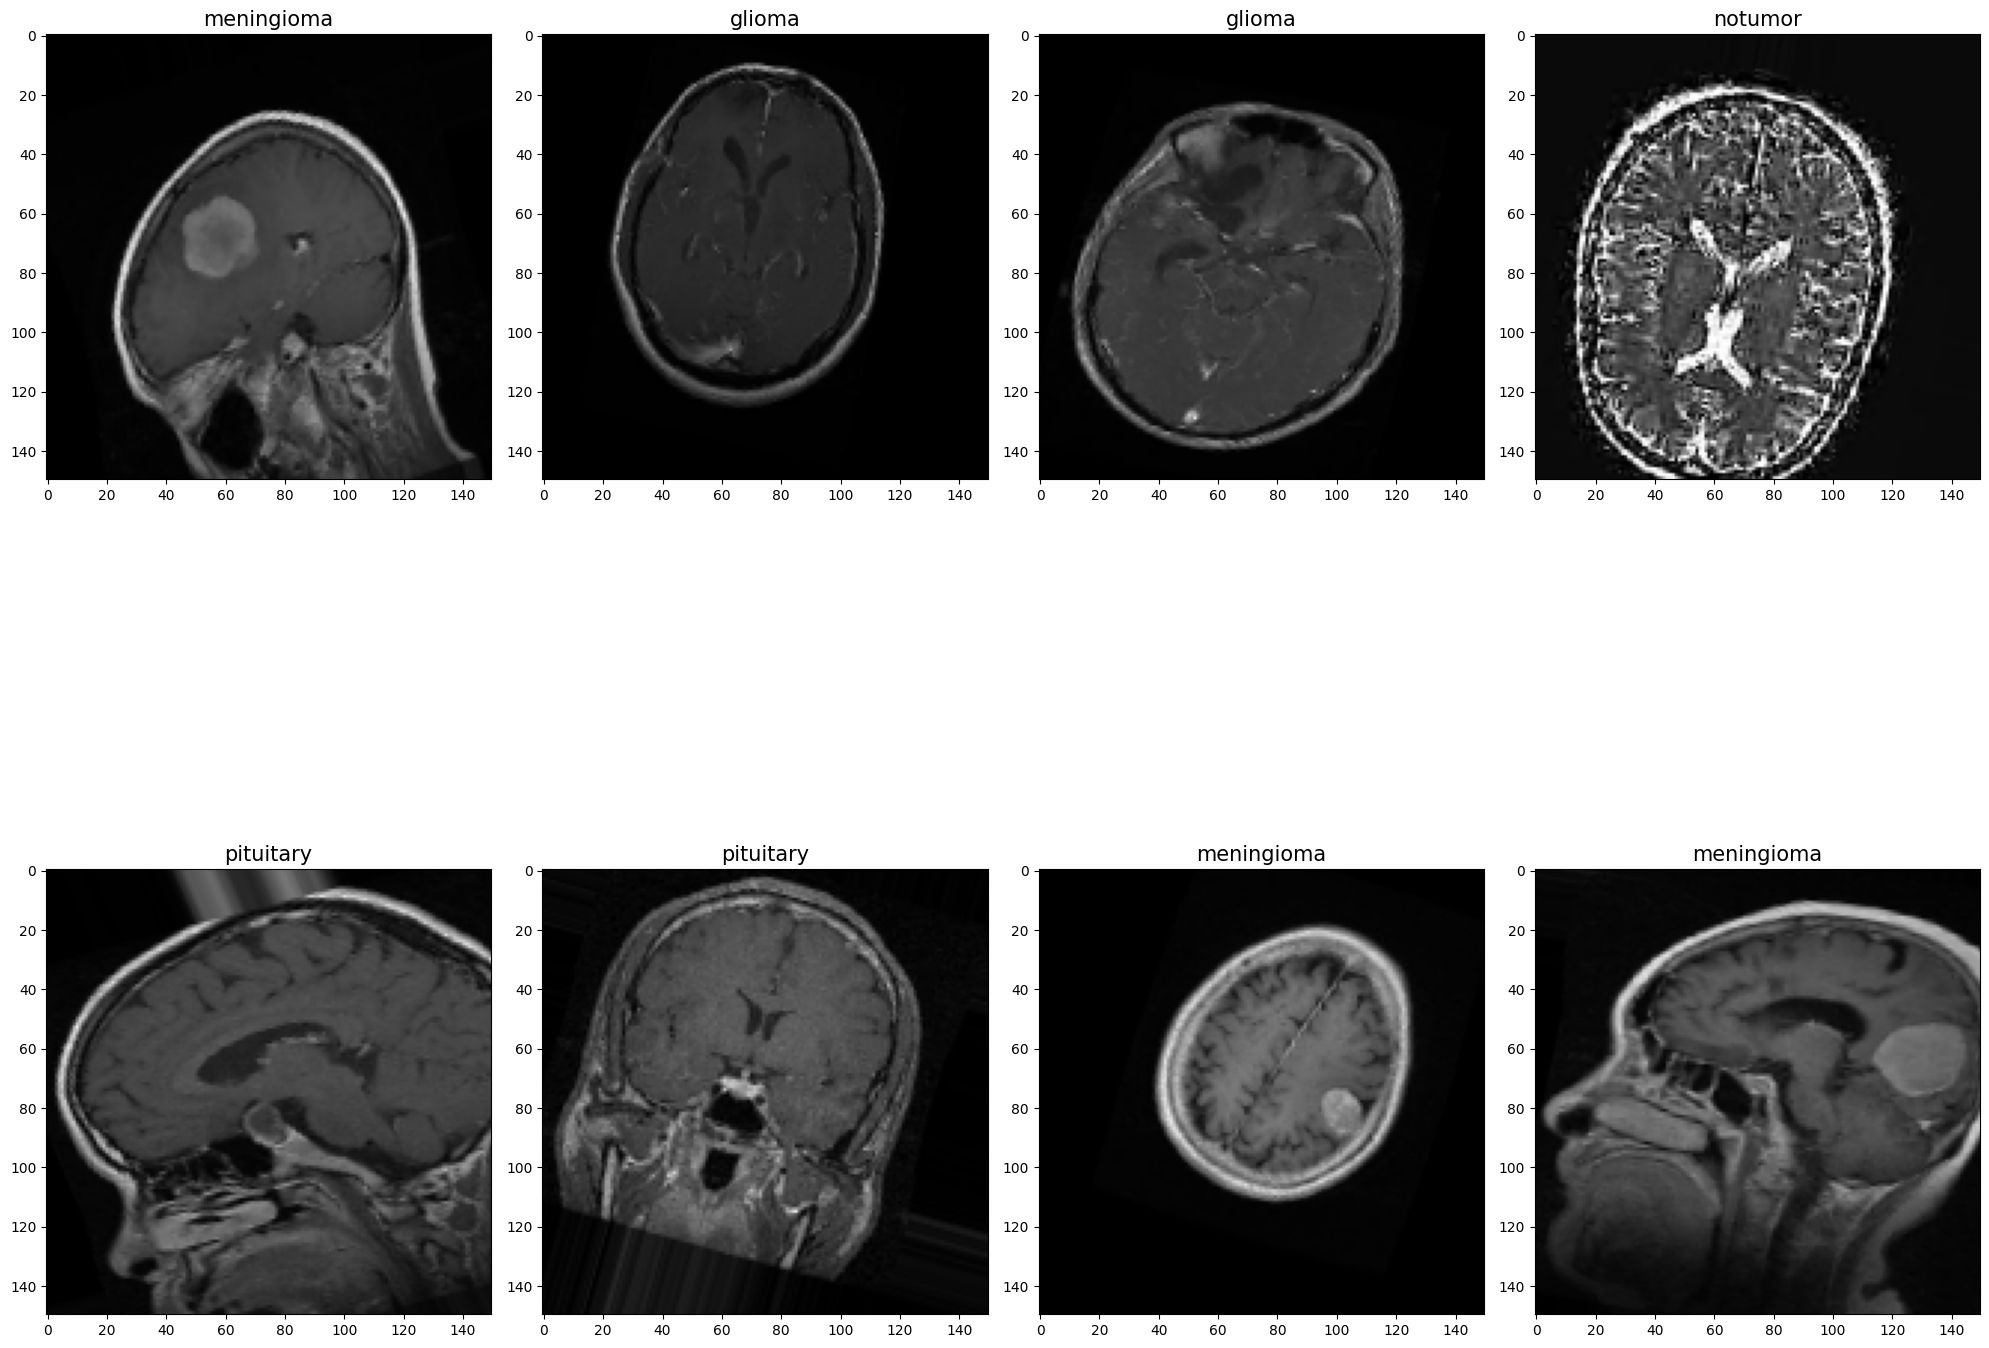

In [22]:
# Visualisasi contoh gambar setelah preprocessing dengan sumbu X dan Y
class_dict = train_generator.class_indices
classes = list(class_dict.keys())
images, labels = next(train_generator)

plt.figure(figsize=(20, 20))

# Tampilkan gambar dataset
for i, (image, label) in enumerate(zip(images[:8], labels[:8])):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

    # Tampilkan ticks (sumbu X dan Y)
    plt.xticks(np.arange(0, image.shape[1], step=20))
    plt.yticks(np.arange(0, image.shape[0], step=20))

plt.tight_layout()
plt.show()


## Modelling

In [24]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D


base_model = EfficientNetB0(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True  # Fine-tuning

model = Sequential([
    base_model,

    # Input layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Additional layers
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 kelas: glioma, meningioma, notumor, pituitary
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 256)      │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,559,047 (17.39 MB)

 Trainable params: 4,517,024 (17.23 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [25]:
# Compile Model dengan Callback
# callback dengan early stopping
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
]

In [26]:
# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 163s 616ms/step - accuracy: 0.5919 - loss: 3.3993 - val_accuracy: 0.2571 - val_loss: 3.3678 - learning_rate: 1.0000e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8438 - loss: 2.3680 - val_accuracy: 0.2536 - val_loss: 3.3655 - learning_rate: 1.0000e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 295ms/step - accuracy: 0.9103 - loss: 2.1381 - val_accuracy: 0.2607 - val_loss: 2.9557 - learning_rate: 1.0000e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9688 - loss: 1.7011 - val_accuracy: 0.2473 - val_loss: 2.9630 - learning_rate: 1.0000e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.9302 - loss: 1.6709 - val_accuracy: 0.3929 - val_loss: 2.5633 - learning_rate: 1.0000e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9062 - loss: 1.5094 - val_accuracy: 0.4000 - val_loss: 2.5488 - learning_rate: 1.0000e-04
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/s

## Evaluasi dan Visualisasi

In [27]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc*100:.2f}%')

# Classification Report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_dict))

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9317 - loss: 0.5530

Test Accuracy: 95.73%
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.99      0.91      0.94       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.90      1.00      0.94       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



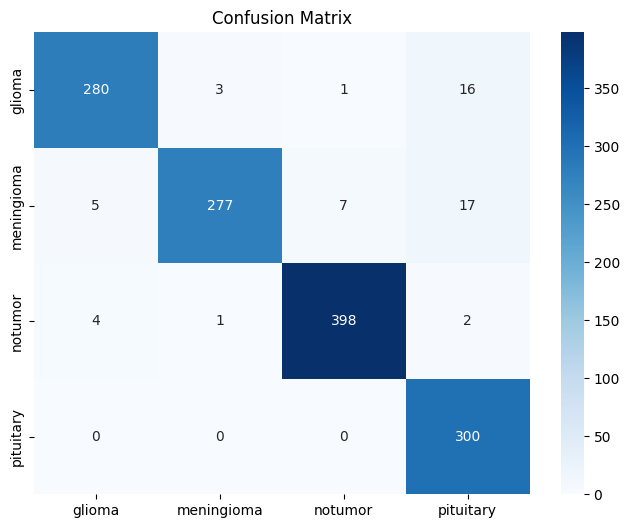

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_dict, yticklabels=class_dict)
plt.title('Confusion Matrix')
plt.show()

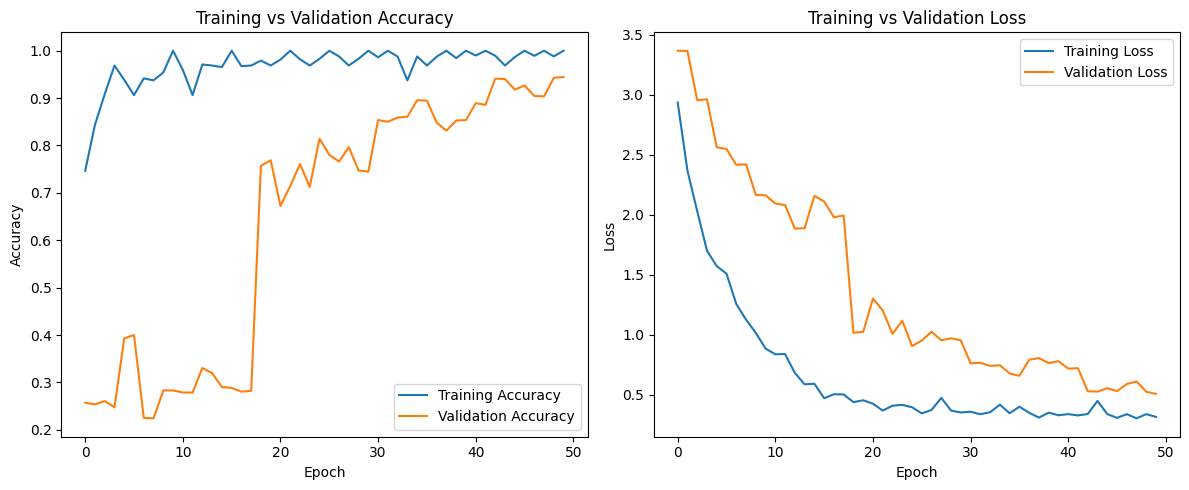

In [29]:
# Plot Akurasi dan Loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

### Format SaveModel

In [30]:
# Setup direktory
base_dir = "/content/"  # path dataset berada
os.makedirs(base_dir, exist_ok=True)

# Simpan sebagai SavedModel
saved_model_dir = os.path.join(base_dir, "saved_model")
os.makedirs(saved_model_dir, exist_ok=True)

# Simpan model
model.export(saved_model_dir)

# Verifikasi
assert os.path.exists(os.path.join(saved_model_dir, "saved_model.pb")), "Gagal menyimpan saved_model.pb"
assert os.path.exists(os.path.join(saved_model_dir, "variables")), "Folder variables tidak ada"
print(f"✔ SavedModel berhasil disimpan di {saved_model_dir}")

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_976')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140497368286032: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140497368294864: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140497371302032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371302416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371303376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371302608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371300112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371304336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371303952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371305296: TensorSpec(shape=(), dtype=tf.resource, n

### Konversi Format TFLite

In [31]:
# Konversi ke TFLite
tflite_dir = os.path.join(base_dir, "tflite")
os.makedirs(tflite_dir, exist_ok=True)

# Konversi model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan model dan label
with open(os.path.join(tflite_dir, "model.tflite"), 'wb') as f:
    f.write(tflite_model)

# Buat label.txt
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
with open(os.path.join(tflite_dir, "label.txt"), 'w') as f:
    f.write('\n'.join(labels))

# Verifikasi
assert os.path.exists(os.path.join(tflite_dir, "model.tflite")), "File TFLite tidak terbuat"
assert os.path.exists(os.path.join(tflite_dir, "label.txt")), "File label tidak terbuat"
print(f"✔ Model TFLite berhasil disimpan di {tflite_dir}")

Saved artifact at '/tmp/tmp5hpcouqw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_976')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140497368286032: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140497368294864: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140497371302032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371302416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371303376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371302608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371300112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371304336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371303952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140497371305296: TensorSpec(shape=(), dtype=tf.resource, name=

### Format TFJS

In [32]:
!pip install tensorflowjs --quiet
import tensorflowjs as tfjs

saved_model_dir = "/content/saved_model"
tfjs_output_dir = "/content/tfjs_model"

# Proses konversi
tfjs.converters.convert_tf_saved_model(
    saved_model_dir,
    tfjs_output_dir
)

print(f"Model berhasil dikonversi ke TFJS dan disimpan di: {tfjs_output_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Model berhasil dikonversi ke TFJS dan disimpan di: /content/tfjs_model


## Inference (Optional)

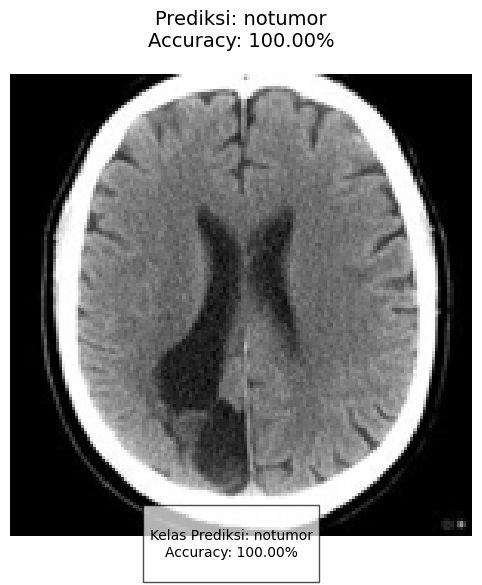


Detail Prediksi:
4. Probabilitas per kelas:
   - glioma: 0.00%
   - meningioma: 0.00%
   - notumor: 100.00%
   - pituitary: 0.00%


In [34]:
# Path model TFLite
tflite_model_path = "/content/tflite/model.tflite"

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Label sesuai urutan pelatihan
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array, img

# inference untuk satu gambar
image_path = "/content/brain-tumor-data/Testing/notumor/Te-noTr_0009.jpg"
input_data, original_img = preprocess_image(image_path)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)
predicted_label = labels[predicted_index]
Accuracy = output_data[0][predicted_index] * 100

# menampilkan gambar dan hasil prediksi
plt.figure(figsize=(8, 6))
plt.imshow(original_img)
plt.title(f"Prediksi: {predicted_label}\nAccuracy: {Accuracy:.2f}%", fontsize=14, pad=20)
plt.axis('off')

# menambahkan kotak informasi
pred_text = f"""
Kelas Prediksi: {predicted_label}
Accuracy: {Accuracy:.2f}%
"""
plt.figtext(0.5, 0.05, pred_text, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.7, "pad":5})

plt.show()

print("\nDetail Prediksi:")
print(f"4. Probabilitas per kelas:")
for i, (label, prob) in enumerate(zip(labels, output_data[0])):
    print(f"   - {label}: {prob*100:.2f}%")

In [35]:
# Membuat requirment.txt
!pip freeze > requirements.txt